**About** : This notebook is used to prepare the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/tviel/work/kaggle_birdclef_2024/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [3]:
import os
import sys
import glob
import json
import torch
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from joblib import delayed
from sklearn.metrics import *

warnings.simplefilter(action="ignore", category=UserWarning)

In [4]:
from params import *
from util.plots import *

from data.preparation import *
from data.dataset import WaveDataset
from data.transforms import get_transfos

from util.logger import create_logger, save_config, prepare_log_folder
from util.torch import init_distributed

from model_zoo.models import define_model
from model_zoo.melspec import FeatureExtractor, CustomTimeMasking, CustomFreqMasking

from training.losses import BirdLoss
from training.main import k_fold

### Data

In [12]:
df = prepare_data()
df_xc = prepare_xenocanto_data()
# df = prepare_nocall_data()

df.sample(5)

,id,filename,primary_label,secondary_labels,rating,path,path_ft,fold
22805,XC211958,whbwoo2/XC211958.ogg,whbwoo2,[],4.0,../input/train_audio/whbwoo2/XC211958.ogg,../input/train_features/whbwoo2/XC211958.hdf5,2
10643,XC580558,graher1/XC580558.ogg,graher1,[],3.5,../input/train_audio/graher1/XC580558.ogg,../input/train_features/graher1/XC580558.hdf5,0
15929,XC845786,kenplo1/XC845786.ogg,kenplo1,[],4.0,../input/train_audio/kenplo1/XC845786.ogg,../input/train_features/kenplo1/XC845786.hdf5,2
13806,XC347592,gyhcaf1/XC347592.ogg,gyhcaf1,[],4.0,../input/train_audio/gyhcaf1/XC347592.ogg,../input/train_features/gyhcaf1/XC347592.hdf5,1
14135,XC371174,hoopoe/XC371174.ogg,hoopoe,[],3.5,../input/train_audio/hoopoe/XC371174.ogg,../input/train_features/hoopoe/XC371174.hdf5,0


In [65]:
df = df[df.secondary_labels.apply(len) > 0]

In [67]:
transforms = get_transfos(augment=True, strength=1)

In [71]:
dataset = WaveDataset(
    df,
    transforms,
    max_len=32000 * 5,
    train=True,
    self_mixup=True,
    secondary_labels_weight=1,
)

In [72]:
# for i in tqdm(range(len(dataset))):
#     # try:
#     x = dataset[i]
#     # except:
#     #     print(i)
#     #     break

In [83]:
wave, y, y_aux, w = dataset[np.random.choice(len(dataset))]
# w = wave
y.sum(), y_aux.sum()

(tensor(2.), tensor(1.))

In [85]:
# display_audio(wave.numpy(), title=", ".join(([CLASSES[int(c)] for c in np.argwhere(y.numpy())[0]])))

In [86]:
# display_audio(w.numpy(), title=", ".join(([CLASSES[int(c)] for c in np.argwhere(y.numpy())[0]])))

### Spectrograms

In [92]:
params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 50,
    "f_max": 15000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": False,
}

aug_config = {
    "specaug_freq": {
        "mask_max_length": 10,
        "mask_max_masks": 3,
        "p": 0.,
    },
    "specaug_time": {
        "mask_max_length": 20,
        "mask_max_masks": 3,
        "p": 0.,
    },
    "mixup":
    {
        "p_audio": 0,
        "p_spec": 0,
        "additive": True,
        "alpha": 4,
        "num_classes": 182,
    }
}

In [93]:
ft_extractor = FeatureExtractor(params, aug_config=aug_config)
ft_extractor = ft_extractor.train()

In [94]:
x = torch.stack([wave, wave])
if len(y.size()) < 2:
    y = torch.stack([y, y])

In [96]:
melspec, _, _, _ = ft_extractor(x)

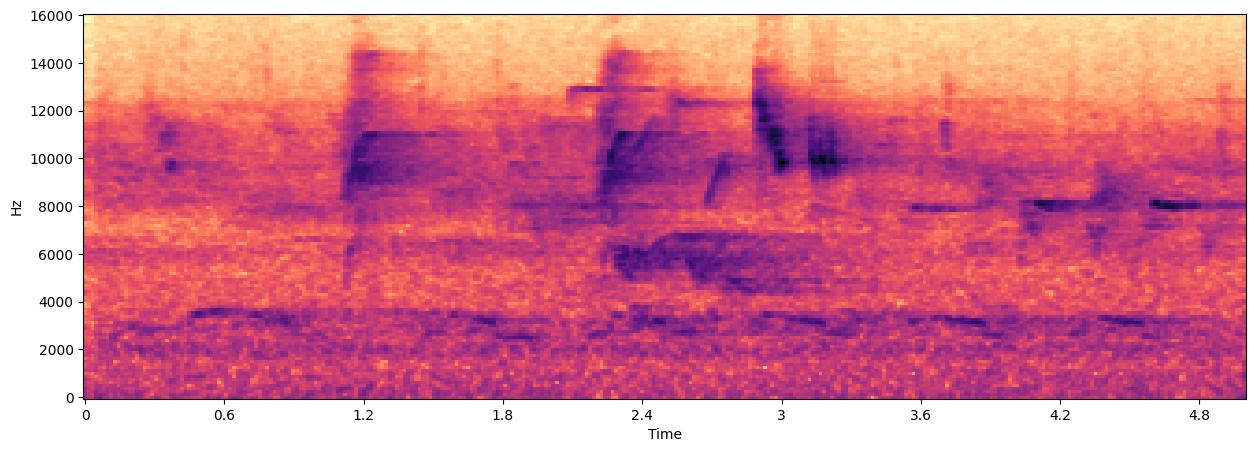

In [97]:
plot_spectrogram(melspec[0].numpy(), params)

In [98]:
# plot_spectrogram(melspec[1].numpy(), params)

### Model

In [99]:
model = define_model(
    "efficientvit_b0", 
    params,
    head="gem",
    n_channels=3,
    num_classes=NUM_CLASSES,
)

Unexpected keys (head.classifier.0.weight, head.classifier.1.bias, head.classifier.1.weight, head.in_conv.conv.weight, head.in_conv.norm.bias, head.in_conv.norm.num_batches_tracked, head.in_conv.norm.running_mean, head.in_conv.norm.running_var, head.in_conv.norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [100]:
pred, _, _, w = model(x, y, y_aux, w)

In [101]:
y.size(), pred.size()

(torch.Size([2, 182]), torch.Size([2, 182]))

In [ ]:
loss = BirdLoss({"name": "bce", "top_k": 0, "ousm_k": 0})
loss(pred, y)

### Train

In [ ]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda"
    save_weights = True

    # Data
    use_nocall = False

    train_duration = 5  # 15, 5
    duration = 5
    random_crop = False

    aug_strength = 1
    self_mixup = True
    normalize = True  # False ??

    melspec_config = {
        "sample_rate": 32000,
        "n_mels": 128,  # 128, 224
        "f_min": 50,
        "f_max": 15000,
        "n_fft": 2048,
        "hop_length": 512,  # 716, 512, 417
        "normalized": True,
    }

    aug_config = {
        "specaug_freq": {
            "mask_max_length": 10,
            "mask_max_masks": 3,
            "p": 0.5,
        },
        "specaug_time": {
            "mask_max_length": 20,
            "mask_max_masks": 3,
            "p": 0.5,
        },
        "mixup":
        {
            "p_audio": 0.5,
            "p_spec": 0.2,
            "additive": True,
            "alpha": 4,
            "num_classes": 182,
        }
    }

    # k-fold
    k = 4
    folds_file = f"../input/folds_{k}.csv"
    selected_folds = [0, 1, 2, 3]

    # Model
    name = "tf_efficientnetv2_s"  # tf_efficientnetv2_s maxvit_tiny_tf_384 eca_nfnet_l0
    pretrained_weights = None

    num_classes = 182
    drop_rate = 0.2
    drop_path_rate = 0.2
    n_channels = 1
    head = "gem"
    reduce_stride = "256" in name

    # Training
    loss_config = {
        "name": "focal_bce",
        "weighted": False,
        "smoothing": 0.,
        "top_k": 0,
        "ousm_k": 0,
        "activation": "sigmoid",  # "softmax"
    }
    secondary_labels_weight = 0.5 if loss_config["name"] == "ce" else 1.

    data_config = {
        "batch_size": 64,
        "val_bs": 256,
        "num_classes": num_classes,
        "num_workers": 8,
    }

    optimizer_config = {
        "name": "Ranger",
        "lr": 5e-3,
        "warmup_prop": 0.0,
        "betas": (0.9, 0.999),
        "max_grad_norm": 0.1,
        "weight_decay": 0.,
    }

    epochs = 1

    use_fp16 = True
    verbose = 1
    verbose_eval = 20

    fullfit = True
    n_fullfit = 1

In [ ]:
DEBUG = True

In [ ]:
log_folder = None
config = Config

if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'\n -> Logging results to {log_folder}\n')

    create_logger(directory=log_folder, name="logs.txt")
    save_config(config, log_folder + "config.json")

init_distributed(config)

In [ ]:
df = prepare_data(DATA_PATH)
# df_xc = prepare_xenocanto_data(DATA_PATH)
# df = pd.concat([df, df_xc], ignore_index=True)

# if DEBUG:
#     df = df.sample(100).reset_index(drop=True)

In [ ]:
k_fold(config, df, log_folder=log_folder)

Done !